In [1]:
import torch
import sys
sys.path.append("/home/msst/repo/Quantization")
import qlib
DEVICE = 'cuda:0'
from qlib.utils.incoherence_preprocessing.incoherence_process_functions import incoherence_process, incoherence_preprocess, incoherence_preprocess_lukashevich, incoherence_process_lukashevich


import matplotlib.pyplot as plt
def plot_hist(data, bins=32, figsize=(4, 4)):
    data_np = data.flatten().numpy()

    plt.figure(figsize=figsize)
    plt.hist(data_np, bins=bins, edgecolor='black')
    plt.grid(True, alpha=0.3)
    plt.show()

In [2]:
model_name='Llama2-7b-hf'
DTYPE = torch.float16
model = qlib.load_model(model_name=model_name, torch_dtype=DTYPE)

module = model.get_decoder().layers[0].self_attn.q_proj
#module = model.get_decoder().layers[10].mlp.down_proj.to(DEVICE)
w = module.weight.data.float().cuda()
w /= w.std()

#w = torch.randn(4096, 4096).cuda()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
w_std_scales = w.std(dim=-1, keepdim=True)
w_std_scales = 2**(w_std_scales.log2().round())

w_std_scaled = w / w_std_scales

w_orig = w * 1
w, SU = incoherence_preprocess_lukashevich(w_std_scaled)
SU = SU.to(DEVICE)

In [4]:
# tlut = torch.randn(2**10, 2)

# params = qlib.TrellisQuantizerParams(
# 	T=256,
# 	L=16,
# 	K=2,
# 	V=2,
# 	decode_mode='load_tlut',
# 	tlut_bits=10,
# )

# quantizer = qlib.TrellisQuantizer(
# 	params=params,
# 	tlut=tlut	
# ).cuda()

# w_q, states = quantizer.quantize(w)

# err  = torch.mean(((w_q - w)**2).reshape(-1, 256), dim=-1)
# print(f"error: {err.mean():.3f} ± {err.std():.3f}")

# err.mean(), err.max(), err.median()

In [5]:
sys.path.append("/home/msst/repo/Quantization/microxcaling")

from mx.elemwise_ops import quantize_elemwise_op
from mx.mx_ops import quantize_mx_op
from mx import finalize_mx_specs
from mx.mx_ops import (
    _get_format_params, _reshape_to_blocks, 
    _shared_exponents, _undo_reshape_to_blocks
)


def get_shared_exps(A, mx_specs, axes):
    block_size = mx_specs['block_size']
    if mx_specs["scale_bits"] == 0:
        scale_bits = 8
    else:
        scale_bits = mx_specs["scale_bits"]
    
    axes = [axes] if type(axes) == int else axes
    axes = [x + A.ndim if x < 0 else x for x in axes]    
    shared_exp_axes = [x + 1 for x in axes] if block_size > 0 else axes
            
    A, axes, orig_shape, padded_shape = _reshape_to_blocks(
        A, axes, block_size
    )

    shared_exp = _shared_exponents(
        A, method=mx_specs['shared_exp_method'], axes=shared_exp_axes, ebits=0,
    )

    emax = _get_format_params(mx_specs['w_elem_format'])[2]
    shared_exp = shared_exp - emax
    
    scale_emax = 2**(scale_bits-1) - 1
    shared_exp[shared_exp > scale_emax] = float("NaN")
    shared_exp[shared_exp < -scale_emax] = -scale_emax
    
    return shared_exp



In [6]:
mx_specs = {
    #'w_elem_format': 'fp4_e2m1',
    #'w_elem_format': 'fp6_e2m3',
    #'w_elem_format': 'fp6_e3m2',
    #'w_elem_format': 'fp8_e4m3',
    'w_elem_format': 'int4',
    #'w_elem_format': 'int8',
    #'a_elem_format': 'fp6_e3m2',
    'block_size': 32,
    'bfloat': 16,
    'custom_cuda': False, #True,
    'quantize_backprop': False,
}
mx_specs = finalize_mx_specs(mx_specs)

In [7]:
axes = [-1]
block_size = mx_specs['block_size']
shared_exp = get_shared_exps(w, mx_specs, axes=axes)

_w, axes, orig_shape, padded_shape = _reshape_to_blocks(w, axes, block_size)
_w_scaled = _w / 1#2**shared_exp
w_scaled = _undo_reshape_to_blocks(_w_scaled, padded_shape, orig_shape, axes)


In [8]:
qis_weight = quantize_mx_op(
    w,
    mx_specs,
    elem_format=mx_specs['w_elem_format'],
    axes=[-1],
    round=mx_specs["round_mx_output"],
)

_qis_weight, axes, orig_shape, padded_shape = _reshape_to_blocks(qis_weight, axes, block_size)
_qis_weight_scaled = _qis_weight / 2**shared_exp

with torch.no_grad():
    uniq_pos = torch.unique(_qis_weight_scaled.abs())



base_codebook_size = 2**10
sample_values = int(base_codebook_size * 1.5)

counts = torch.zeros_like(uniq_pos)
for i, v in enumerate(uniq_pos):
    counts[i] = (_qis_weight_scaled.abs()==v).sum()
    # if v == 0.0:
    #     counts[i] /= 2

freq = (counts / counts.sum()).unsqueeze(0)


freq_2d = freq.T @ freq
counts = (freq_2d * sample_values / freq_2d.sum())
counts = counts.round()
counts = counts.flatten()

unique_cb_h = uniq_pos.repeat(len(uniq_pos), 1)
unique_cb_v = unique_cb_h.T
unique_cb_2d = torch.stack([unique_cb_v, unique_cb_h], dim=0)

unique_cb = unique_cb_2d.reshape(2, -1).T

cb = []
for i, c in enumerate(counts):
    cb += int(c) * [unique_cb[i],]
    
cb = torch.stack(cb)
n_to_remove = len(cb)- base_codebook_size
torch.manual_seed(0)
tlut = cb[torch.randperm(len(cb))][n_to_remove:]

assert list(tlut.shape) == [base_codebook_size, 2]

In [9]:
tlut = tlut / torch.unique(tlut).max() * 3

In [10]:
params = qlib.TrellisQuantizerParams(
    T=256,
    L=16,
    K=2,
    V=2,
    decode_mode='load_tlut',
    tlut_bits=10,
)

quantizer = qlib.TrellisQuantizer(
    params=params,
    tlut=tlut	
).cuda()

w_scaled_q, states = quantizer.quantize(w_scaled)

#w_scaled_q = w_scaled_q * 4 / 3
_w_scaled_q, axes, orig_shape, padded_shape = _reshape_to_blocks(w_scaled_q, axes, block_size)
_w_q = _w_scaled_q * 1#2**shared_exp
w_q = _undo_reshape_to_blocks(_w_q, padded_shape, orig_shape, axes)

###
w_q = incoherence_process_lukashevich(w_q, SU) * w_std_scales
w = w_orig
###

w_q_grouped = w_q.reshape(-1, 256)
w_grouped = w.reshape(-1, 256)

# Вычисляем среднеквадратичную ошибку по каждой группе
err = torch.mean((w_q_grouped - w_grouped) ** 2, dim=-1)
#err  = torch.mean(((w_q - w)**2).reshape(-1, 256), dim=-1)
print(f"error: {err.mean():.3f} ± {err.std():.3f}")


# N(0, 1)
# 0.079 fp4_e2m1
# 0.079 fp6_e2m3
# 0.079 fp6_e3m2
# 0.079 int4

# layers.0.self_attn.q_proj
# 0.075 ± 0.105 fp4_e2m1
# 0.072 ± 0.103 fp6_e2m3
# 0.073 ± 0.103 fp6_e3m2
# 0.069 ± 0.098 int4

# layers.10.mlp.down_proj
# 0.079 ± 0.018 fp4_e2m1
# 0.079 ± 0.019 fp6_e2m3
# 0.079 ± 0.021 fp6_e3m2
# 0.078 ± 0.019 int4



100%|██████████| 256/256 [00:19<00:00, 12.92it/s]


error: 0.076 ± 0.098


In [11]:
top5_err, top5_indices = torch.topk(err, k=5, largest=True)

top5_indices

tensor([61166, 61156, 60102, 61300, 60106], device='cuda:0')

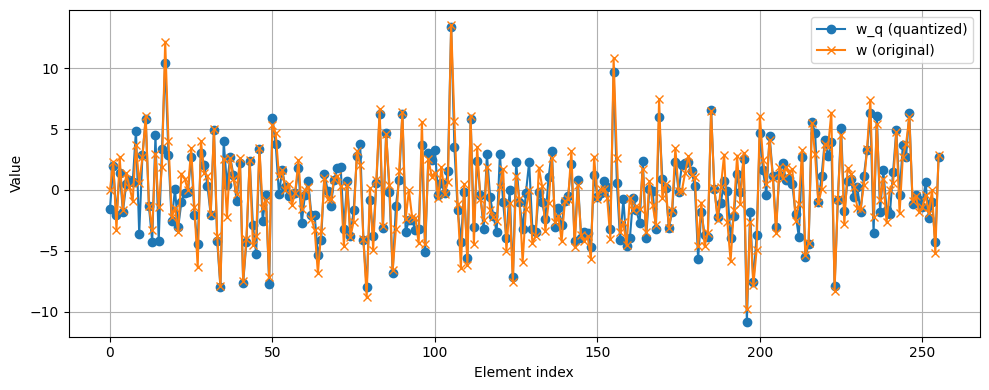

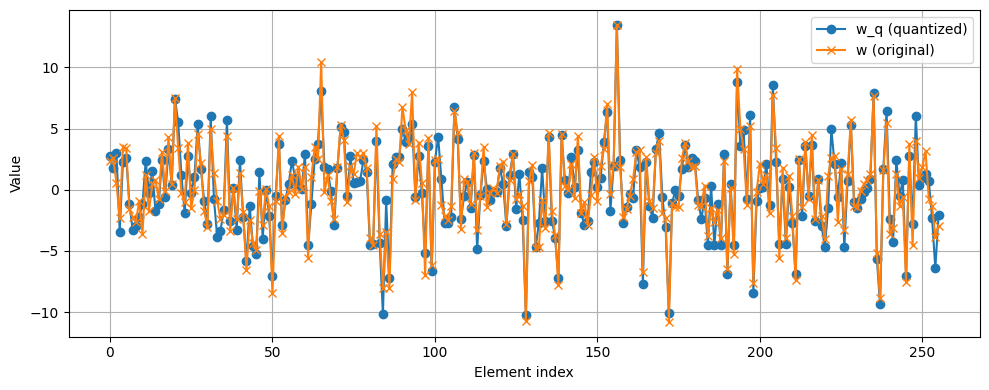

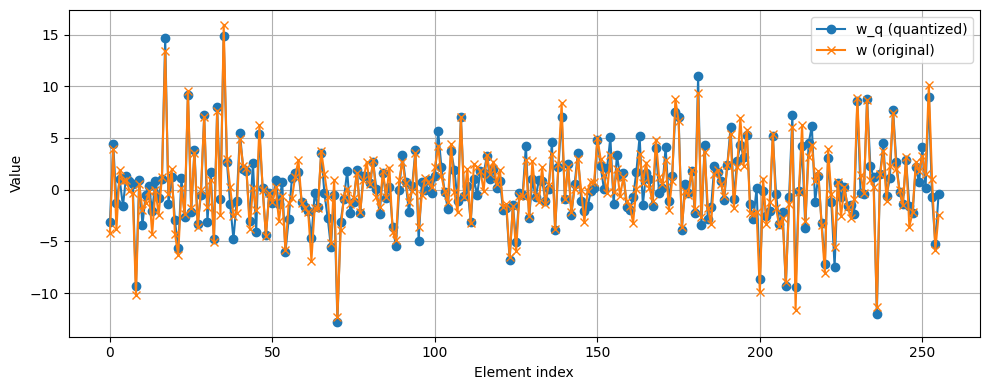

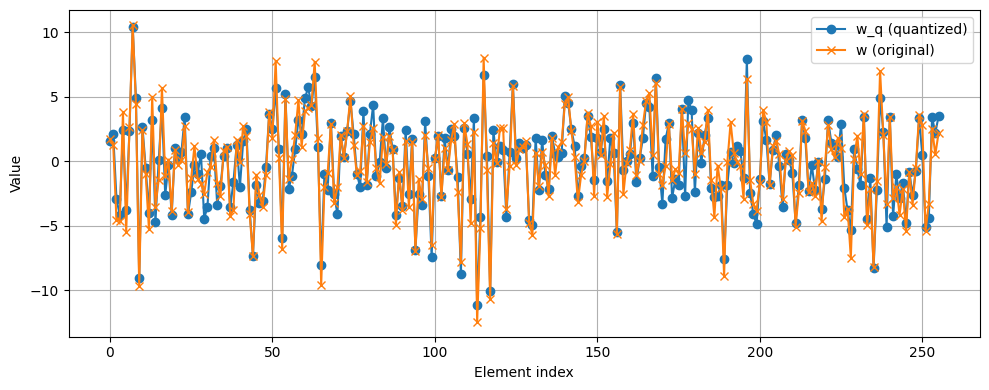

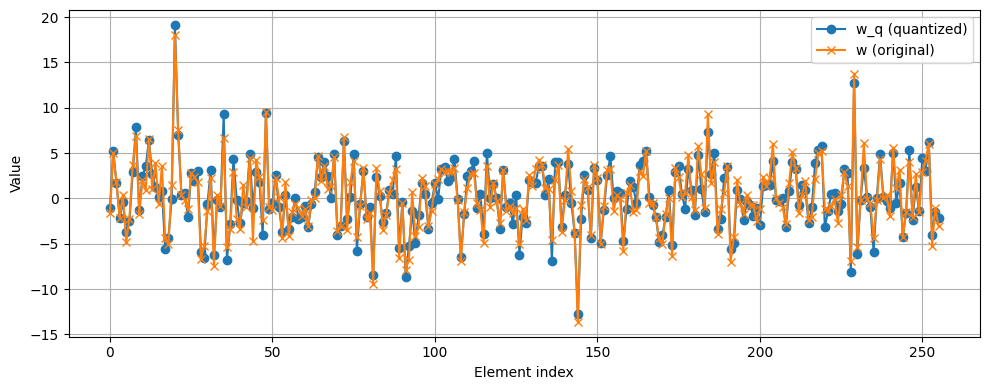

In [12]:
import matplotlib.pyplot as plt

def plot_diff(w, w_q):
	plt.figure(figsize=(10, 4))
	plt.plot(w_q, label='w_q (quantized)', marker='o')
	plt.plot(w, label='w (original)', marker='x')
	plt.xlabel('Element index')
	plt.ylabel('Value')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

for idx in top5_indices:
	plot_diff(w_grouped[idx].cpu(), w_q_grouped[idx].cpu())

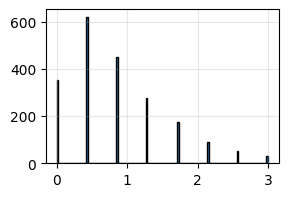

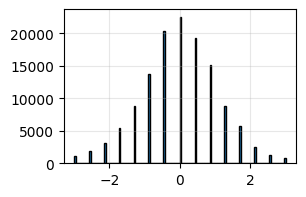

In [13]:
plot_hist(quantizer.tlut.cpu(), bins=128, figsize=(3, 2))
plot_hist(quantizer.lut.cpu(), bins=128, figsize=(3, 2))